### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy.stats import norm
import pywt
from aeon.classification.distance_based import ElasticEnsemble, ShapeDTW, KNeighborsTimeSeriesClassifier
from aeon.datasets import load_classification
from aeon.benchmarking.results_loaders import get_estimator_results
from aeon.datasets.tsc_data_lists import univariate_equal_length
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from tqdm import tqdm
import timeit
from datetime import timedelta

In [18]:
algos = ['1nn']

# Para cada conjunto de dados na lista
total_time = 0
for dataset_name in univariate_equal_length:
    # Carregue os dados de treinamento e teste
    X_train, y_train = load_classification(dataset_name, extract_path="./Temp/", split="TRAIN")
    X_test, y_test = load_classification(dataset_name, extract_path="./Temp/", split="test")
    
    # Achatando os dados para 2D, pois alguns algoritmos esperam 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    dataset_accuracies = []
    # Para cada algoritmo
    for algo in algos:
        # Treinar o modelo e fazer previsões
        start = timeit.default_timer()
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train_flat, y_train, base_option='svm', meta_option=algo)
        predictions_test_meta = predict_with_meta_classifier(X_test_flat, trained_base_models, meta_classifier)
        stop = timeit.default_timer()
        total_time += stop - start
        real_time = str(timedelta(seconds=total_time))
        
        # Calcular a acurácia e armazená-la
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        dataset_accuracies.append(test_accuracy_meta)
        
        
        print(f"Acurácia do modelo {algo} para {dataset_name}: {test_accuracy_meta}")
        print('Time runtime (seconds): ', real_time)
        
np.savetxt("Results_1NN_.csv", dataset_accuracies, delimiter=",")

Testing Instances: 100%|##########| 16800/16800 [02:41<00:00, 103.95it/s]


Acurácia do modelo 1nn para Crop: 0.7192857142857143
Time runtime (seconds):  1:41:16.280276


Testing Instances: 100%|##########| 638/638 [00:02<00:00, 239.07it/s]


Acurácia do modelo 1nn para WordSynonyms: 0.5752351097178683
Time runtime (seconds):  1:41:30.503790


Testing Instances: 100%|##########| 315/315 [00:00<00:00, 398.88it/s]


Acurácia do modelo 1nn para GunPointOldVersusYoung: 1.0
Time runtime (seconds):  1:41:31.513406


Testing Instances: 100%|##########| 242/242 [00:01<00:00, 157.39it/s]


Acurácia do modelo 1nn para OSULeaf: 0.6487603305785123
Time runtime (seconds):  1:41:35.389764


Testing Instances: 100%|##########| 455/455 [00:02<00:00, 177.33it/s]


Acurácia do modelo 1nn para FiftyWords: 0.6571428571428571
Time runtime (seconds):  1:41:44.230093


Testing Instances: 100%|##########| 150/150 [00:00<00:00, 351.79it/s]


Acurácia do modelo 1nn para GunPoint: 0.9133333333333333
Time runtime (seconds):  1:41:44.755240


Testing Instances: 100%|##########| 2345/2345 [00:28<00:00, 83.63it/s]


Acurácia do modelo 1nn para Mallat: 0.9543710021321962
Time runtime (seconds):  1:42:13.053982


Testing Instances: 100%|##########| 205/205 [00:00<00:00, 380.60it/s]


Acurácia do modelo 1nn para ProximalPhalanxOutlineAgeGroup: 0.8097560975609757
Time runtime (seconds):  1:42:22.347959


Testing Instances: 100%|##########| 249/249 [00:02<00:00, 121.64it/s]


Acurácia do modelo 1nn para InsectEPGRegularTrain: 1.0
Time runtime (seconds):  1:42:24.504694


Testing Instances: 100%|##########| 276/276 [00:00<00:00, 368.21it/s]


Acurácia do modelo 1nn para DistalPhalanxOutlineCorrect: 0.6702898550724637
Time runtime (seconds):  1:45:18.949549


Testing Instances: 100%|##########| 2425/2425 [00:28<00:00, 84.29it/s]


Acurácia do modelo 1nn para MixedShapesSmallTrain: 0.8639175257731959
Time runtime (seconds):  1:45:48.047196


Testing Instances: 100%|##########| 249/249 [00:01<00:00, 131.10it/s]


Acurácia do modelo 1nn para InsectEPGSmallTrain: 1.0
Time runtime (seconds):  1:45:50.001959


Testing Instances: 100%|##########| 3840/3840 [00:13<00:00, 280.68it/s]


Acurácia do modelo 1nn para ChlorineConcentration: 0.896875
Time runtime (seconds):  1:54:32.911785


Testing Instances: 100%|##########| 390/390 [00:02<00:00, 190.31it/s]


Acurácia do modelo 1nn para CricketX: 0.6333333333333333
Time runtime (seconds):  1:54:45.658502


Testing Instances: 100%|##########| 1380/1380 [00:24<00:00, 55.85it/s]


Acurácia do modelo 1nn para CinCECGTorso: 0.8072463768115942
Time runtime (seconds):  1:55:10.808472


Testing Instances: 100%|##########| 500/500 [00:10<00:00, 46.97it/s]


Acurácia do modelo 1nn para EthanolLevel: 0.816
Time runtime (seconds):  1:55:54.334690


Testing Instances: 100%|##########| 306/306 [00:01<00:00, 204.56it/s]


Acurácia do modelo 1nn para DiatomSizeReduction: 0.9575163398692811
Time runtime (seconds):  1:55:55.887415


Testing Instances: 100%|##########| 291/291 [00:00<00:00, 363.90it/s]


Acurácia do modelo 1nn para MiddlePhalanxOutlineCorrect: 0.7010309278350515
Time runtime (seconds):  1:57:35.467016


Testing Instances: 100%|##########| 362/362 [00:05<00:00, 63.13it/s]


Acurácia do modelo 1nn para EOGVerticalSignal: 0.45027624309392267
Time runtime (seconds):  1:57:46.416181


Testing Instances: 100%|##########| 1896/1896 [00:19<00:00, 95.39it/s]


Acurácia do modelo 1nn para Phoneme: 0.14451476793248946
Time runtime (seconds):  1:58:09.803139


Testing Instances: 100%|##########| 2425/2425 [00:24<00:00, 97.49it/s] 


Acurácia do modelo 1nn para MixedShapesRegularTrain: 0.8849484536082475
Time runtime (seconds):  1:58:44.172115


Testing Instances: 100%|##########| 8236/8236 [01:26<00:00, 95.48it/s] 


Acurácia do modelo 1nn para StarLightCurves: 0.952525497814473
Time runtime (seconds):  2:14:06.623450


Testing Instances: 100%|##########| 2850/2850 [00:10<00:00, 260.43it/s]


Acurácia do modelo 1nn para FreezerRegularTrain: 0.9821052631578947
Time runtime (seconds):  2:14:17.818612


Testing Instances: 100%|##########| 316/316 [00:00<00:00, 396.51it/s]


Acurácia do modelo 1nn para GunPointMaleVersusFemale: 0.9968354430379747
Time runtime (seconds):  2:14:20.533177


Testing Instances: 100%|##########| 1690/1690 [00:05<00:00, 309.11it/s]


Acurácia do modelo 1nn para FaceAll: 0.8301775147928994
Time runtime (seconds):  2:14:27.763132


Testing Instances: 100%|##########| 50/50 [00:01<00:00, 44.10it/s]


Acurácia do modelo 1nn para Rock: 0.8
Time runtime (seconds):  2:14:28.974614


Testing Instances: 100%|##########| 1980/1980 [00:07<00:00, 271.16it/s]


Acurácia do modelo 1nn para InsectWingbeatSound: 0.6136363636363636
Time runtime (seconds):  2:14:36.895675


Testing Instances: 100%|##########| 73/73 [00:00<00:00, 248.08it/s]


Acurácia do modelo 1nn para Lightning7: 0.7123287671232876
Time runtime (seconds):  2:14:37.404395


Testing Instances: 100%|##########| 100/100 [00:00<00:00, 284.54it/s]


Acurácia do modelo 1nn para Trace: 0.87
Time runtime (seconds):  2:14:37.920044


Testing Instances: 100%|##########| 861/861 [00:02<00:00, 410.20it/s]


Acurácia do modelo 1nn para ECGFiveDays: 1.0
Time runtime (seconds):  2:14:40.074136


Testing Instances: 100%|##########| 300/300 [00:00<00:00, 486.65it/s]


Acurácia do modelo 1nn para SyntheticControl: 0.9533333333333334
Time runtime (seconds):  2:17:54.796308


Testing Instances: 100%|##########| 77/77 [00:00<00:00, 95.69it/s] 


Acurácia do modelo 1nn para Worms: 0.5714285714285714
Time runtime (seconds):  2:18:01.294597


Testing Instances: 100%|##########| 600/600 [00:08<00:00, 72.59it/s]


Acurácia do modelo 1nn para SemgHandGenderCh2: 0.8133333333333334
Time runtime (seconds):  2:18:16.336951


Testing Instances: 100%|##########| 4500/4500 [00:12<00:00, 348.00it/s]


Acurácia do modelo 1nn para ECG5000: 0.9073333333333333
Time runtime (seconds):  2:18:30.578352


Testing Instances: 100%|##########| 60/60 [00:00<00:00, 180.97it/s]


Acurácia do modelo 1nn para Car: 0.8666666666666667
Time runtime (seconds):  2:18:31.056127


Testing Instances: 100%|##########| 205/205 [00:00<00:00, 426.17it/s]


Acurácia do modelo 1nn para ProximalPhalanxTW: 0.7317073170731707
Time runtime (seconds):  2:18:32.318738


Testing Instances: 100%|##########| 601/601 [00:01<00:00, 538.43it/s]


Acurácia do modelo 1nn para SonyAIBORobotSurface1: 0.7470881863560732
Time runtime (seconds):  2:18:33.481591


Training Base Models:  20%|##        | 1/5 [00:00<00:02,  1.43it/s]

### Dados

In [2]:
try:
    train_data = pd.read_parquet('MSC\CSV_Dissertação\Parquet_Dissertacao\Coffee_TRAIN.parquet')
    test_data = pd.read_parquet('MSC\CSV_Dissertação\Parquet_Dissertacao\Coffee_TEST.parquet')
except FileNotFoundError:
    print("Ensure the Parquet files are in the correct path.")
    raise

In [3]:
X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

### Função de transformação dos dados.

In [4]:
def sax_transform(series, w, a):
    paa = [series[i:i + w].mean() for i in range(0, len(series), w)]
    
    if np.std(paa) != 0:
        paa = (paa - np.mean(paa)) / np.std(paa)
    else:
        paa = paa - np.mean(paa)
    
    breakpoints = norm.ppf(np.linspace(0, 1, a+1)[1:-1])
    sax_symbols = np.array(range(a))
    sax_representation = sax_symbols[np.digitize(paa, breakpoints)]
    
    return sax_representation

def transform_data(X, num_features=30):
    a = 3
    w = int(X.shape[1] / num_features)  # Ajuste do tamanho da janela baseado no número de características desejado
    
    X_sax = np.array([sax_transform(row, w, a) for row in X])
    X_fft = np.abs(fft(X, axis=1))
    
    coeffs_cA, coeffs_cD = pywt.dwt(X, 'db4', axis=1)
    X_dwt = np.hstack((coeffs_cA, coeffs_cD))
    
    X_paa = np.column_stack([X[:, i:i+2].mean(axis=1) for i in range(0, X.shape[1], 2)])

    return {
        "TS": X,
        "FFT": X_fft,
        "DWT": X_dwt,
        "PAA": X_paa,
        "SAX": X_sax
    }

### Seleção do modelo extrator e modelo classificador

In [5]:
def select_model(option, random_state):
    if option == '1nn':
        return KNeighborsTimeSeriesClassifier(distance='euclidean', n_neighbors=1)
    elif option == '3nn':
        return KNeighborsTimeSeriesClassifier(distance='dtw', n_neighbors=3)
    elif option == 'svm':
        return svm.SVC(C=1000, gamma=0.1, kernel='linear', probability=True)
    elif option == 'gbc':
        return GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif option == 'nb':
        return GaussianNB()
    elif option == 'shape':
        return ShapeDTW()
    elif option == 'ee':
        return ElasticEnsemble(proportion_of_param_options= 0.5,
                               proportion_train_in_param_finding= 0.5,
                               proportion_train_for_test=0.5,
                               n_jobs=-1,
                               random_state=random_state,
                               majority_vote=True)
    else:
        return RandomForestClassifier(n_estimators=100,random_state=random_state)

### Treino do modelos extrator e classificador

In [6]:
def train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='1nn', random_state=42):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    
    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):
        model = select_model(base_option, random_state)
        model.fit(X_trans, y_train)
        trained_models[rep] = model
        
    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, model in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        meta_features.append(instance_features)
    
    meta_features = np.array(meta_features)
    np.savetxt("meta-features-train.csv", meta_features, delimiter=",")
    
    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier

### Predicao do meta-classificador

In [7]:
def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste
    
    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data(x_instance)
        
        instance_features = []
        for rep, model in trained_base_models.items():
            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        
        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões
        
        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista
    
    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    # Salvar todos os meta-recursos dos dados de teste em um arquivo CSV
    np.savetxt("meta-features-test.csv", meta_features_test, delimiter=",")
    
    return predictions


### Testando um único modelo - Random Forest como extrator e SVM como meta-classificador

In [8]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='svm', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 28/28 [00:01<00:00, 20.89it/s]

Accuracy: 1.0


In [9]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='ee', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models: 100%|##########| 5/5 [00:00<00:00, 570.75it/s]


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 124.91it/s]

Accuracy: 1.0


In [10]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='shape', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 28/28 [00:00<00:00, 221.62it/s]

Accuracy: 1.0


### Testando um único modelo - SVM como extrator e meta-classificador

In [11]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='svm', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)
print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 28/28 [00:00<00:00, 292.45it/s]

Accuracy: 1.0


In [12]:
#Teste utilizando o classificador SVM
meta_attrib_train = np.loadtxt("meta-features-train.csv", delimiter=",")
meta_attrib_test = np.loadtxt("meta-features-test.csv", delimiter=",")

clf = svm.SVC(probability=True)
clf.fit(meta_attrib_train, y_train)
y_hat = clf.predict(meta_attrib_test)
test_accuracy_meta = np.mean(y_hat == y_test)
print(f"accuracy: {test_accuracy_meta}")

accuracy: 1.0


In [13]:
clf_2 = svm.SVC(probability=True)
clf_2.fit(X_train, y_train)
y_hat_ = clf_2.predict(X_test)
test_accuracy_meta_2 = np.mean(y_hat_ == y_test)
print(f"accuracy: {test_accuracy_meta_2}")

accuracy: 0.9285714285714286


### Gráfico das diferenças de dados

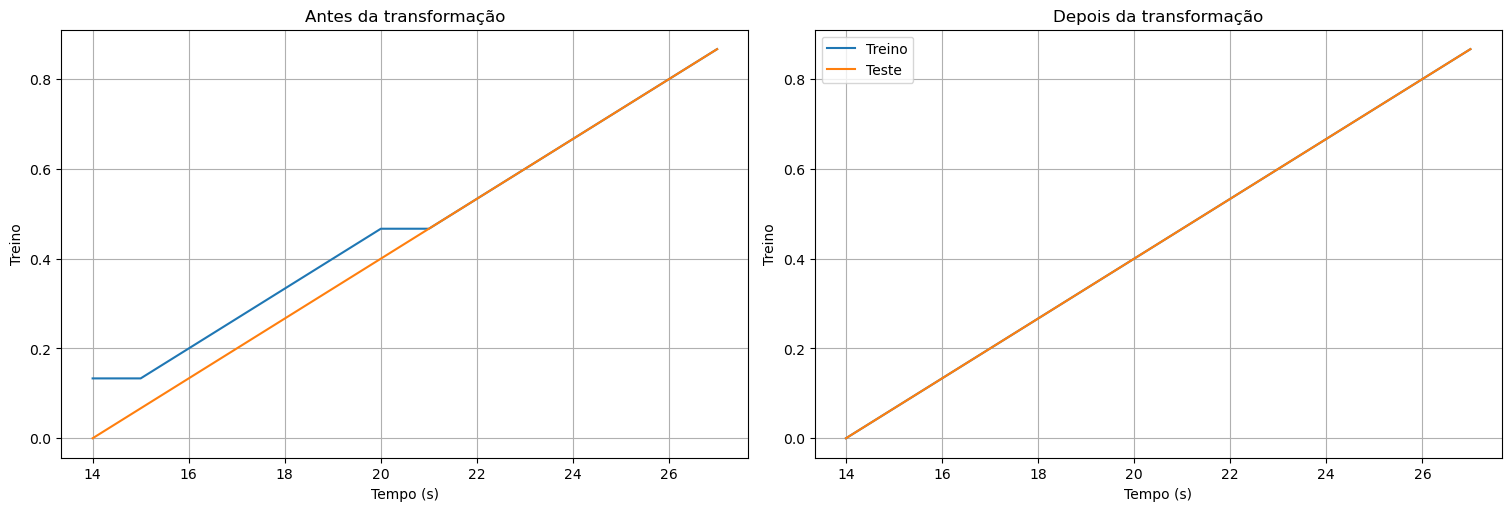

In [14]:
import matplotlib.pyplot as plt

y1 = y_hat  # depois da transformação
y2 = y_test  

z1 = y_hat_ #antes da transformação
z2 = y_test

#suavizar os dados do gráfico
window_size = 15
y1_smoothed = pd.Series(y1).rolling(window=window_size).mean()
y2_smoothed = pd.Series(y2).rolling(window=window_size).mean()
z1_smoothed = pd.Series(z1).rolling(window=window_size).mean()
z2_smoothed = pd.Series(z2).rolling(window=window_size).mean()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), layout='constrained')

# Conjunto de validação do classificador
axs[0].set_title('Antes da transformação')
axs[0].plot(z1_smoothed, label='Treino')
axs[0].plot(z2_smoothed, label='Teste')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Treino')
axs[0].grid(True)

# Conjunto de validação do meta-classificador
axs[1].set_title('Depois da transformação')
axs[1].plot(y1_smoothed, label='Treino')
axs[1].plot(y2_smoothed, label='Teste')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Treino')
axs[1].grid(True)

plt.legend()
plt.show()



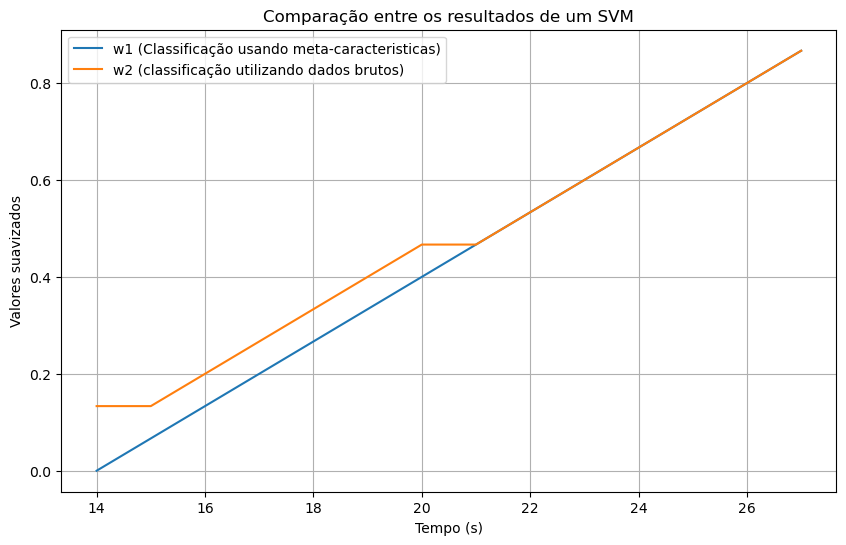

In [15]:
w1 = y_hat  # meta-classificador
w2 = y_hat_ #classificação

# Suavizar os dados do gráfico
window_size = 15
w1_smoothed = pd.Series(w1).rolling(window=window_size).mean()
w2_smoothed = pd.Series(w2).rolling(window=window_size).mean()

# Plotar os dados
plt.figure(figsize=(10, 6))
plt.plot(w1_smoothed, label='w1 (Classificação usando meta-caracteristicas)')
plt.plot(w2_smoothed, label='w2 (classificação utilizando dados brutos)')
plt.xlabel('Tempo (s)')
plt.ylabel('Valores suavizados')
plt.title('Comparação entre os resultados de um SVM')
plt.legend()
plt.grid(True)
plt.show()


### Treino em loop de todas as opções de classificadores disponiveis no Select Model.

In [16]:
algos = ['1nn', '3nn', 'svm', 'nb', 'gbc', 'ee', 'shape']
for algo in algos:
    
    print(f'Meta-classificador com modelo extrator {algo.upper()}')
    
    # Training
    try:
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option=algo)
        # Testing
        predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)
    
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        print(f'Acurácia do teste usando o meta-classificador com modelo extrator {algo}: {test_accuracy_meta}')
    except Exception as e:
        print(f"Ocorreu um erro no teste com o {algo}: {e}")
    print("-------------------------------")
print('RF (10x)')
for i in range(1):
    print(f'RF: Random seed = {i}')
    try:
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='random_forest', random_state=i)
    
        # Testing
        predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)
    
        test_accuracy = np.mean(predictions_test_meta == y_test)
        print(f'Acurácia do teste usando seed {i}: {test_accuracy}')
    except Exception as e:
        print(f"Ocorreu um erro no teste com o RF (seed {i}): {e}")
    print("-------------------------------")

Meta-classificador com modelo extrator 1NN


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 201.96it/s]


Acurácia do teste usando o meta-classificador com modelo extrator 1nn: 1.0
-------------------------------
Meta-classificador com modelo extrator 3NN


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 210.71it/s]


Acurácia do teste usando o meta-classificador com modelo extrator 3nn: 1.0
-------------------------------
Meta-classificador com modelo extrator SVM


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 240.21it/s]


Acurácia do teste usando o meta-classificador com modelo extrator svm: 1.0
-------------------------------
Meta-classificador com modelo extrator NB


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 240.02it/s]


Acurácia do teste usando o meta-classificador com modelo extrator nb: 1.0
-------------------------------
Meta-classificador com modelo extrator GBC


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 239.75it/s]


Acurácia do teste usando o meta-classificador com modelo extrator gbc: 1.0
-------------------------------
Meta-classificador com modelo extrator EE


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 186.47it/s]


Acurácia do teste usando o meta-classificador com modelo extrator ee: 1.0
-------------------------------
Meta-classificador com modelo extrator SHAPE


Testing Instances: 100%|##########| 28/28 [00:00<00:00, 198.52it/s]


Acurácia do teste usando o meta-classificador com modelo extrator shape: 1.0
-------------------------------
RF (10x)
RF: Random seed = 0


Testing Instances: 100%|##########| 28/28 [00:01<00:00, 19.54it/s]

Acurácia do teste usando seed 0: 1.0
-------------------------------
